# PDF → Tables workflow (pdfplumber + OpenAI): Lawyer Statistics 

This notebook uses OpenAI + PdfPlumber to converted Lawyer stats from a set of text based *table-heavy PDFs* into **clean, analysis-ready tables** (CSV / JSON). 

Why this matters (in practice):
- Even if it is text based, PDFs are meant for *presentation formats*. Thus tables may often be split across pages, have merged cells, or contain layout artifacts (OpenAI told me this).
- `pdfplumber` is great at **finding and extracting** many tables, but the output can be messy (misaligned columns, wrapped text, split headers).
- LLMs can be used as a **post-processor**: take “almost-a-table” output and convert it to a clean, consistent schema—**as long as you keep the input small and structured** and validate the results.

**Steps:**  
1) Preview the PDF (visual sanity check)
2) Extract pages with `pdfplumber`,
3) Send selected tables to OpenAI, to normalize it to a frame of desire. In this case, only county statistics are needed
5) Double check, sending missing counties to OpenAI again
6) Export + visualize results.

**What I got**
1) Json is always better, stabler, and easier to process afterwards
2) When the table is large enough, extract table instead of page
3) Because the return is big, yet only a few counties were missing, so this 'two rounds' procedure has good effect
4) Basically I am treating OpenAI as a clumsy assistant. Do it once not enough? then do it twice.
5) The pdf is text based, but for image based, similar stratgy can be applied (though much more costly)
6) PdfPlumber is hard to manuver, or I do not know.


## 0) Setup
including the packages needed and paths

In [ ]:
# %pip install pdfplumber pandas matplotlib pillow openai
import os
from pathlib import Path
import json
import csv
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt

import pdfplumber 

In [ ]:
# === PATH SETTINGS ===
NOTEBOOK_DIR = Path.cwd()    # this is where the current notebook located, not the folder of the project
PROJ_DIR = NOTEBOOK_DIR.parent

if str(PROJ_DIR) not in sys.path:
    sys.path.insert(0, str(PROJ_DIR))
    # i took an easy pass, simply define the project folder (which including the child folder for functions,
    # rather than 'find' it
    # and then simply insert the project folder in sys.path

PDF_PATH = Path(r"C:\Users\46798566\Data_Research\Attorney_States_PDF")
    # folder contains PDFs. county info needs to be extracted from them
        # the following coodes are for selecting one and debug...uncomment them when it is necessary
        # PDF1_PATH = [*PDF_PATH.glob("*.pdf")][1]    
        # 

OUT_DIR = PROJ_DIR / "outputs"
    # outputs will be saved here (folder already set up)



# Optional: if you want strict filtering by a keyword in the final table
# (e.g., "County") set this; otherwise leave as None.
# FINAL_ROW_KEYWORD = "County"

# print("PDF_PATH:", PDF_PATH)
# print("OUT_DIR:", OUT_DIR.resolve())

table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "text",
    # "intersection_tolerance": 5,
    # "snap_tolerance": 3,
    # "join_tolerance": 6,
    # "edge_min_length": 3,
}

## 1) Preview the PDF
**Preview a random page (defined as 7 here)**

In [690]:
%%capture
from src.pdf_preview import render_pdf_page
page_number = 7
im = render_pdf_page(PDF1_PATH, page_number=page_number, dpi=160)
plt.figure(figsize=(5, 6))
plt.title(f"PDF preview — page {page_number}")

Illustration:

(np.float64(-0.5), np.float64(1359.5), np.float64(1759.5), np.float64(-0.5))

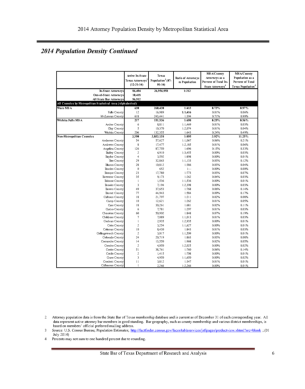

In [691]:
plt.imshow(im)
plt.axis("off")

## 2) Scan pages
and select the pages we need for each document

In [96]:
# chatgpt actually think I should score the pages first. but as I tried before, this is not the currect path...
from src.table_detection import page_keep, select_page_numbers
    # import the page functions... 
# select_page_numbers(pdf_path: str, county_number_threshold:int = 3) -> list
# the following code tests the code on one file:
# importlib.reload(src.table_detection)
# import importlib
# select_page_numbers(PDF1_PATH)

In [ ]:
%%capture captured_output   
    # output stored in captured_output
# get the pages that needs to be sent to chatgpt
PDF_FILES = [*PDF_PATH.glob("*.pdf")]  # for this task, PDF_FILES are given, so I'm using the upper case
pages_pased = []
for pdf_file in PDF_FILES:
    page_ix = select_page_numbers(pdf_file)
    pdf = pdfplumber.open(pdf_file)
        # here there is a tiny problem is i will have to use pdfplumber to open the file twice in total 
        # (once here, once in the select_page_number func), and it might not be efficient enough
    for ix, v in page_ix.items():
        page_content = pdf.pages[ix].extract_text()
        pages_pased.append({
            "docu_name": pdf_file.name,          # the file name (without path)
            "page_index": ix,
            "text": page_content,
            "potential_counties_number": v,
        })

**Why send only selected tables to OpenAI?**

LLMs work best when:
- the input is **small enough** to fit comfortably in context,
- the structure is **consistent** (one table at a time),
- budget concern, imagine if the pdf has one thousand pages yet you only want 10 pages to be analyzed


## 5) OpenAI: normalize the extracted table into clean JSON/CSV
### the following code setup OpenAI

In [285]:
# IMPORTANT: Do NOT hard-code API keys in notebooks you may share.
# Set your key in environment variables instead:
#   setx OPENAI_API_KEY "your-key"   (PowerShell/CMD, then restart terminal)
# or set it in your session:
#   os.environ["OPENAI_API_KEY"] = "..."

from openai import OpenAI
# importlib.reload(src.prompts)
from src.prompts import generate_openai_prompt
import json

# === DEFAULT PARAMETERS ===
OPENAI_MODEL = "gpt-5.2"  # OpenAI model
KEY_PATH = Path.home() / "Github" /"openai_key.txt"
os.environ["OPENAI_API_KEY"] = KEY_PATH.read_text().strip()  # set up openAI key
client = OpenAI()


In [ ]:
# --------------------------------------------------
# Send selected PDF pages to OpenAI and collect tables
# --------------------------------------------------
        # {p["docu_name"] for p in pages_pased}   # check the names of docs
# importlib.reload(src.table_detection)
from src.table_detection import extract_begin_year

# Optional: restrict processing to a small set of PDFs (debug only), uncomment to run
TEST_DOCNAMES = {"PopulationDensityReport11-12.pdf",  'AttorneyPopulationDensity2016-17.pdf'}

dfs = [] # list of per page dateframe 
for page in pages_pased:
    # == debug test == 
    if TEST_DOCNAMES and page["docu_name"] not in TEST_DOCNAMES:
        continue
    # == debug test ends== 

    # --- build prompt for each page 
    txt_input = page['text']
    prompt = generate_openai_prompt(txt_input, 'json')

    # --- call openAI 
    resp = client.responses.create(
        model=OPENAI_MODEL,
        input=prompt,
        )
    print(f"message recieved, for file {page['docu_name']}, page {page['page_index']}.")
    data = json.loads(resp.output_text)
    df = pd.DataFrame(data)

    # --- add per page row index and other meta data
    df.insert(0, "row_in_page", range(len(df)))   # 0 means the position of the col inserted !!!!!
    df['docu_name'] = page["docu_name"]   #    pages_pased[2]['page_index']
    df['page_number'] = page['page_index'] # which page in the pdf file? may not be the same as the number printed...
    df['potential_counties_detected'] = page['potential_counties_number']
    begin_year = extract_begin_year(page["docu_name"] )
    df.insert(1, "year_document", begin_year))  # year, based on the document's name
    dfs.append(df)

In [347]:
combined_df = pd.concat(dfs, ignore_index=True)

In [352]:
# --- output as a csv 
from datetime import datetime

OUT_DIR = PROJ_DIR / "data_outputs" / "tables"
ts = datetime.now().strftime("%Y%m%d_%H%M")
out_file_name = f'output_table_{ts}.csv'

In [354]:
# --- cleaned the data a little bit and then send to  
final_df = combined_df.copy()
    # begin_year = final_df["docu_name"].apply(extract_begin_year)
    # final_df.insert(1, "year_doc", begin_year)
final_df["Name"] = final_df["Name"].str.lstrip(".")  #final_df.loc[:, "Name"] = final_df["Name"].str.lstrip(".")
final_df = final_df[~final_df["Name"].str.contains(r"\bMSA\b", na=False)]   #~ means drop
final_df.to_csv(OUT_DIR / out_file_name, index=False)

In [462]:
# --- check if all 254 counties were collected...
texas_counties = pd.read_csv(PROJ_DIR/'data_source'/'texas_counties.csv')
years = set( final_df['year_doc'] )

missing_counties = []
for year in years:
    sorted_final_df = texas_counties[['FIPS_names']].merge(
                        final_df.loc[ final_df['year_doc']== year ] ,
                        right_on = 'Name',   # left_on vs right_on
                        left_on = 'FIPS_names',
                        how = 'left'
                    )
    missing_names = sorted_final_df[sorted_final_df['Name'].isna()]['FIPS_names']
    missing_county = dict()
    if not missing_names.empty:
        print(f"{missing_names.values} missing in {year} data")        
        missing_county["county"] = missing_names.values
        missing_county['year'] = str(year)
        missing_county['docu_name'] = final_df.loc[ final_df['year_doc']== year, 'docu_name'].iloc[0]
        missing_counties.append(missing_county) 
    else:
        print(f'no missing values in {year} data')
    #missing_counties.extend(missing_names)  # missing names is a list

['Lynn County'] missing in 2016 data
no missing values in 2011 data


## 6) Double check, ask OpenAI to check again

In [ ]:
# -- Identify the source of missing, which page, and ask open AI to double check again
    # search the page which contains the name
    # make sure the page belongs to the correct doc (pdf)

def page_mentioned_word(page_text, county_name):
    county_name = county_name.replace(r"County", "").strip()
    return (county_name in page_text )
pages_doublecheck = []
for file in missing_counties:   # each file has a list of missing counties
    for county_name in file["county"]:
        page_doublecheck = dict()
        page_doublecheck['county'] = county_name
        page_doublecheck['year'] = file['year']
        candidate_pages = [
            p for p in pages_pased
            if page_mentioned_word(p["text"], county_name) and p["docu_name"] == file["docu_name"]
        ]     
        page_doublecheck['page_info'] = candidate_pages
        pages_doublecheck.append(page_doublecheck)

# p = pages_pased[5]
# page_mentioned_word(pages_pased[3]["text"] , 'Lynn County')

In [ ]:
# --- go over the missing counties and regenerate the rows..
# importlib.reload(src.prompts)
from src.prompts import generate_openai_prompt_doublecheck
headers = final_df.columns.tolist()[2:7]
rows_regenerated = []
for page_doublecheck in pages_doublecheck:
    for page_selected in page_doublecheck['page_info']:
        page_text = page_selected['text']
        target_county = page_doublecheck['county']
        headers_formated = ", ".join(headers)
        output_format = 'json'
        prompt = generate_openai_prompt_doublecheck (page_text, target_county, output_format, headers_formated)
        print(prompt)

            # --- call openAI 
        resp = client.responses.create(
            model=OPENAI_MODEL,
            input=prompt,
            )
        print(f"""
Message recieved, for county {target_county} in file {page_selected['docu_name']} (page {page_selected['page_index']}). 
Here it is 
{resp.output_text}
""")
        data = json.loads(resp.output_text)
        df = pd.DataFrame(data)
        df.insert(0, "row_in_page", 0)
        df['year_doc'] = page_doublecheck['year']
        df['docu_name'] = page_selected['docu_name']
        df["page_number"] = page_selected['page_index']
        df['newly_added']= 'Yes'
    rows_regenerated.append(df)

In [660]:
# --- combine the double checked df with the previous one and save
ts = datetime.now().strftime("%Y%m%d_%H%M")
out_file_name = f'output_table_{ts}.csv'
rows_regenerated_df = pd.concat(rows_regenerated)
final_second_run =  pd.concat([final_df, rows_regenerated_df] , ignore_index=True)
final_second_run.to_csv(OUT_DIR / out_file_name, index=False)

## 8) Result visualization (save a picture)

In [696]:
# this is assisted by OpenAI
def dataframe_to_png(df: pd.DataFrame, out_path: Path, max_rows: int = 25, max_cols: int = 10):
    """Render a DataFrame as a simple image."""
    show = df.iloc[:max_rows, :max_cols].copy()
    fig, ax = plt.subplots(figsize=(min(7, 1.2*max_cols), min(5, 0.4*max_rows + 2)))
    ax.axis("off")
    tbl = ax.table(
        cellText= show.astype(str).fillna("").values,
        colLabels=show.columns.tolist(),
        loc="center",
        cellLoc="left"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.3)
    fig.tight_layout()
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    #plt.close(fig)

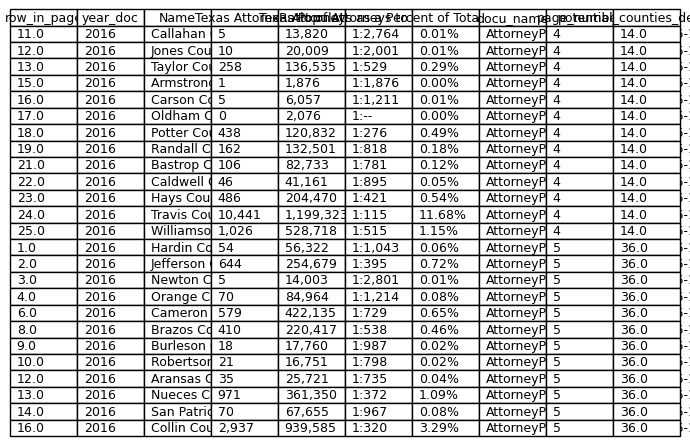

Saved: C:\Users\46798566\GitHub\PdfScanner_Attorney\data_outputs\figures\result_preview.png


In [695]:
# Example:
dataframe_to_png(final_second_run, PROJ_DIR / "data_outputs"/ "figures" / "result_preview.png")
print("Saved:", (PROJ_DIR / "data_outputs"/ "figures" / "result_preview.png").resolve())

## Notes / Next improvements
- If tables are image-based (scanned), pdfplumber won’t see text; you’ll need OCR.
- For multi-page tables, you can detect repeated headers and stitch pages together before sending to OpenAI.
- For high-stakes data, add stronger validation:
  - expected row counts (e.g., 254 counties)
  - allowed value ranges
  - strict schema (column names + types)
